# **Minimize KL-divergence between two distributions**


In [183]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

try:
    import distrax
except:
    %pip install -qq distrax
    import distrax
try:
    import optax
except:
    %pip install -qq optax
    import optax
try:
    import seaborn as sns
except:
    %pip install -qq seaborn
    import seaborn as sns
try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled
latexify(width_scale_factor=1.6, fig_height=1.0)

/home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [184]:
# generating a bimodal distribution q
mix = 0.5
mean_one, mean_two = 1, 10
scale_one, scale_two = 1, 1.5
q = distrax.MixtureSameFamily(
    mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
    components_distribution=distrax.Normal(loc=[mean_one, mean_two], scale=[scale_one, scale_two]),
)

/home/shobro/anaconda3/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


In [185]:
key = jax.random.PRNGKey(1234)


def kl_sampling(params, q, samples=100000):  # loss function when KL(p:q)
    p = distrax.Normal(loc=params[0], scale=params[1])
    sample_set = p.sample(seed=key, sample_shape=samples)
    return jnp.mean(p.log_prob(sample_set) - q.log_prob(sample_set))


def kl_sampling_inverse(params, q, samples=100000):  # loss function when KL(q:p)
    p = distrax.Normal(loc=params[0], scale=params[1])
    sample_set = q.sample(seed=key, sample_shape=samples)
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [186]:
def fit(params, optimizer, loss_fun, n_itr):
    opt_state = optimizer.init(params)
    loss = []
    for i in range(n_itr):
        samples = 100000
        loss_value, grads = jax.value_and_grad(loss_fun)(params, q, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss.append(loss_value)
    return params, loss

In [187]:
optimizer = optax.adam(learning_rate=0.05)
n_itr = 450
params_one = jnp.array([5.0, 8.0])
optimized_params_one, loss_one = fit(params=params_one, optimizer=optimizer, loss_fun=kl_sampling, n_itr=n_itr)
params_two = jnp.array([5.0, 10.0])
optimized_params_two, loss_two = fit(params=params_two, optimizer=optimizer, loss_fun=kl_sampling_inverse, n_itr=n_itr)

Text(0.5, 1.0, 'Iteration vs loss\n$\\min_{p}\\ KL[q ; p]$')

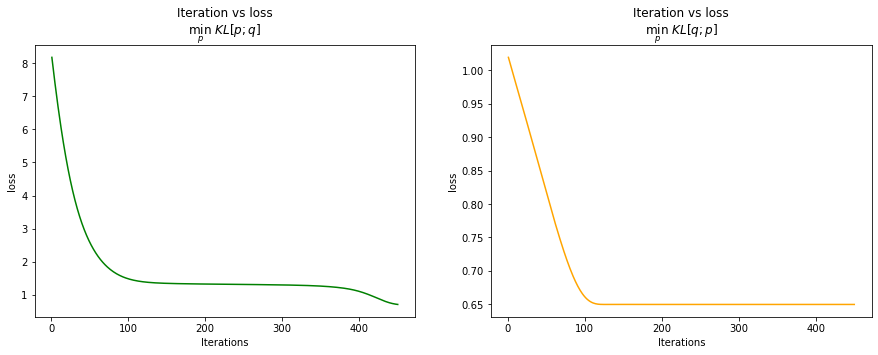

In [188]:
x_loss = jnp.linspace(1, n_itr, n_itr)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(x_loss, loss_one, color="green")
ax2.plot(x_loss, loss_two, color="orange")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("loss")
ax1.set_title("Iteration vs loss\n" + r"$\min_{p}\ KL[p ; q]$")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("loss")
ax2.set_title("Iteration vs loss\n" + r"$\min_{p}\ KL[q ; p]$")

/home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


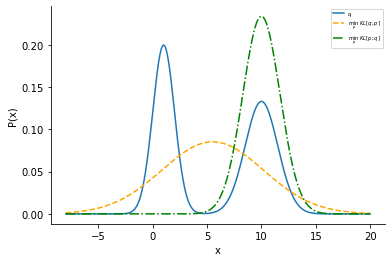

In [191]:
fig, ax = plt.subplots(1, 1)
x = jnp.linspace(-8, 20, int(1e6))
label_one = str()
label_two = str()
if is_latexify_enabled():
    label_one = r"$$ \min_p\ KL[p ; q]$$"
    label_two = r"$$ \min_p\ KL[q ; p]$$"
else:
    label_one = r"$\min_p\ KL[p ; q]$"
    label_two = r"$\min_p\ KL[q ; p]$"
ax.plot(x, q.prob(x), label="q")
ax.plot(
    x,
    distrax.Normal(loc=optimized_params_two[0], scale=optimized_params_two[1]).prob(x),
    color="orange",
    label=label_two,
    linestyle="--",
)
ax.plot(
    x,
    distrax.Normal(loc=optimized_params_one[0], scale=optimized_params_one[1]).prob(x),
    color="green",
    label=label_one,
    linestyle="-.",
)
ax.set_xlabel("x")
ax.set_ylabel("P(x)")
ax.legend(fontsize=5.2, loc="upper right")
sns.despine()
savefig("minimize_kl_divergence_latexified")